In [1]:
from matplotlib import pyplot as plt
import numpy as np
import h5py

In [2]:
# load dataset
dataset = h5py.File('3dshapes.h5', 'r')
print(dataset.keys())
images = dataset['images']  # array shape [480000,64,64,3], uint8 in range(256)
labels = dataset['labels']  # array shape [480000,6], float64
image_shape = images.shape[1:]  # [64,64,3]
label_shape = labels.shape[1:]  # [6]
n_samples = labels.shape[0]  # 10*10*10*8*4*15=480000

_FACTORS_IN_ORDER = ['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape',
                     'orientation']
_NUM_VALUES_PER_FACTOR = {'floor_hue': 10, 'wall_hue': 10, 'object_hue': 10, 
                          'scale': 8, 'shape': 4, 'orientation': 15}

<KeysViewHDF5 ['images', 'labels']>


In [3]:
# methods for sampling unconditionally/conditionally on a given factor
def get_index(factors):
  """ Converts factors to indices in range(num_data)
  Args:
    factors: np array shape [6,batch_size].
             factors[i]=factors[i,:] takes integer values in 
             range(_NUM_VALUES_PER_FACTOR[_FACTORS_IN_ORDER[i]]).

  Returns:
    indices: np array shape [batch_size].
  """
  indices = 0
  base = 1
  for factor, name in reversed(list(enumerate(_FACTORS_IN_ORDER))):
    indices += factors[factor] * base
    base *= _NUM_VALUES_PER_FACTOR[name]
  return indices


def sample_random_batch(batch_size):
  """ Samples a random batch of images.
  Args:
    batch_size: number of images to sample.

  Returns:
    batch: images shape [batch_size,64,64,3].
  """
  indices = np.random.choice(n_samples, batch_size)
  ims = []
  for ind in indices:
    im = images[ind]
    im = np.asarray(im)
    ims.append(im)
  ims = np.stack(ims, axis=0)
  ims = ims / 255. # normalise values to range [0,1]
  ims = ims.astype(np.float32)
  return ims.reshape([batch_size, 64, 64, 3])


def sample_batch(batch_size, fixed_factor, fixed_factor_value):
  """ Samples a batch of images with fixed_factor=fixed_factor_value, but with
      the other factors varying randomly.
  Args:
    batch_size: number of images to sample.
    fixed_factor: index of factor that is fixed in range(6).
    fixed_factor_value: integer value of factor that is fixed 
      in range(_NUM_VALUES_PER_FACTOR[_FACTORS_IN_ORDER[fixed_factor]]).

  Returns:
    batch: images shape [batch_size,64,64,3]
  """
  factors = np.zeros([len(_FACTORS_IN_ORDER), batch_size],
                     dtype=np.int32)
  for factor, name in enumerate(_FACTORS_IN_ORDER):
    num_choices = _NUM_VALUES_PER_FACTOR[name]
    factors[factor] = np.random.choice(num_choices, batch_size)
  factors[fixed_factor] = fixed_factor_value
  print(factors[5])
  indices = get_index(factors)
  ims = []
  for ind in indices:
    im = images[ind]
    im = np.asarray(im)
    ims.append(im)
  ims = np.stack(ims, axis=0)
  ims = ims / 255. # normalise values to range [0,1]
  ims = ims.astype(np.float32)
  return ims.reshape([batch_size, 64, 64, 3])

In [35]:
def show_images_grid(imgs_, num_images=25):
  ncols = int(np.ceil(num_images**0.5))
  nrows = int(np.ceil(num_images / ncols))
  _, axes = plt.subplots(nrows, ncols, figsize=(nrows * 3, ncols * 3))
  axes = axes.flatten()

  for ax_i, ax in enumerate(axes):
    if ax_i < num_images:
      ax.imshow(imgs_[ax_i], cmap='Greys_r', interpolation='nearest')
      ax.set_xticks([])
      ax.set_yticks([])
    else:
      ax.axis('off')

def show_images_row(imgs_, Y = None):
  plt.rc('text', usetex=True)
  plt.rc('font', family='serif')
  plt.rc('font', size=22)
  plt.rc('legend', fontsize=22)
  plt.rc('xtick', labelsize=20)
  plt.rc('ytick', labelsize=20)
  num_images = len(imgs_)
  fig , axes = plt.subplots(1, num_images, figsize=(num_images * 3, 3))
  axes = axes.flatten()

  for ax_i, ax in enumerate(axes):
    if ax_i < num_images:
      ax.imshow(imgs_[ax_i], cmap='Greys_r', interpolation='nearest')
      ax.set_xticks([])
      ax.set_yticks([])
    else:
      ax.axis('off')
    # if Y is not None, add a Y label to the image with the corresponding Y, 
    if Y is not None:
      ax.set_xlabel(r'$ y = $' +  str(Y[ax_i]))
  # tight layout and reduced padding
  fig.tight_layout()
  fig.subplots_adjust(wspace=-.5, hspace=0)

  # fig.savefig('figures/samples_3dshapes.pdf', bbox_inches='tight', dpi = 300) 
    
def show_images_grid(imgs_, Y = None, num_images=25):
  plt.rc('text', usetex=True)
  plt.rc('font', family='serif')
  plt.rc('font', size=22)
  plt.rc('legend', fontsize=22)
  plt.rc('xtick', labelsize=20)
  plt.rc('ytick', labelsize=20)
  ncols = int(np.ceil(num_images**0.5))
  nrows = int(np.ceil(num_images / ncols))
  fig, axes = plt.subplots(nrows, ncols, figsize=(nrows * 2, ncols * 2))
  axes = axes.flatten()

  for ax_i, ax in enumerate(axes):
    if ax_i < num_images:
      ax.imshow(imgs_[ax_i], cmap='Greys_r', interpolation='nearest')
      ax.set_xticks([])
      ax.set_yticks([])
      if Y is not None:
        ax.set_xlabel(r'$ y = $ ' +  str(Y[ax_i]), fontsize=24)
      
    else:
      ax.axis('off')
  fig.tight_layout()
  fig.subplots_adjust(wspace=-0.5, hspace=0.4, )

  fig.savefig('figures/samples_3dshapes.pdf', bbox_inches='tight', dpi = 300) 
     

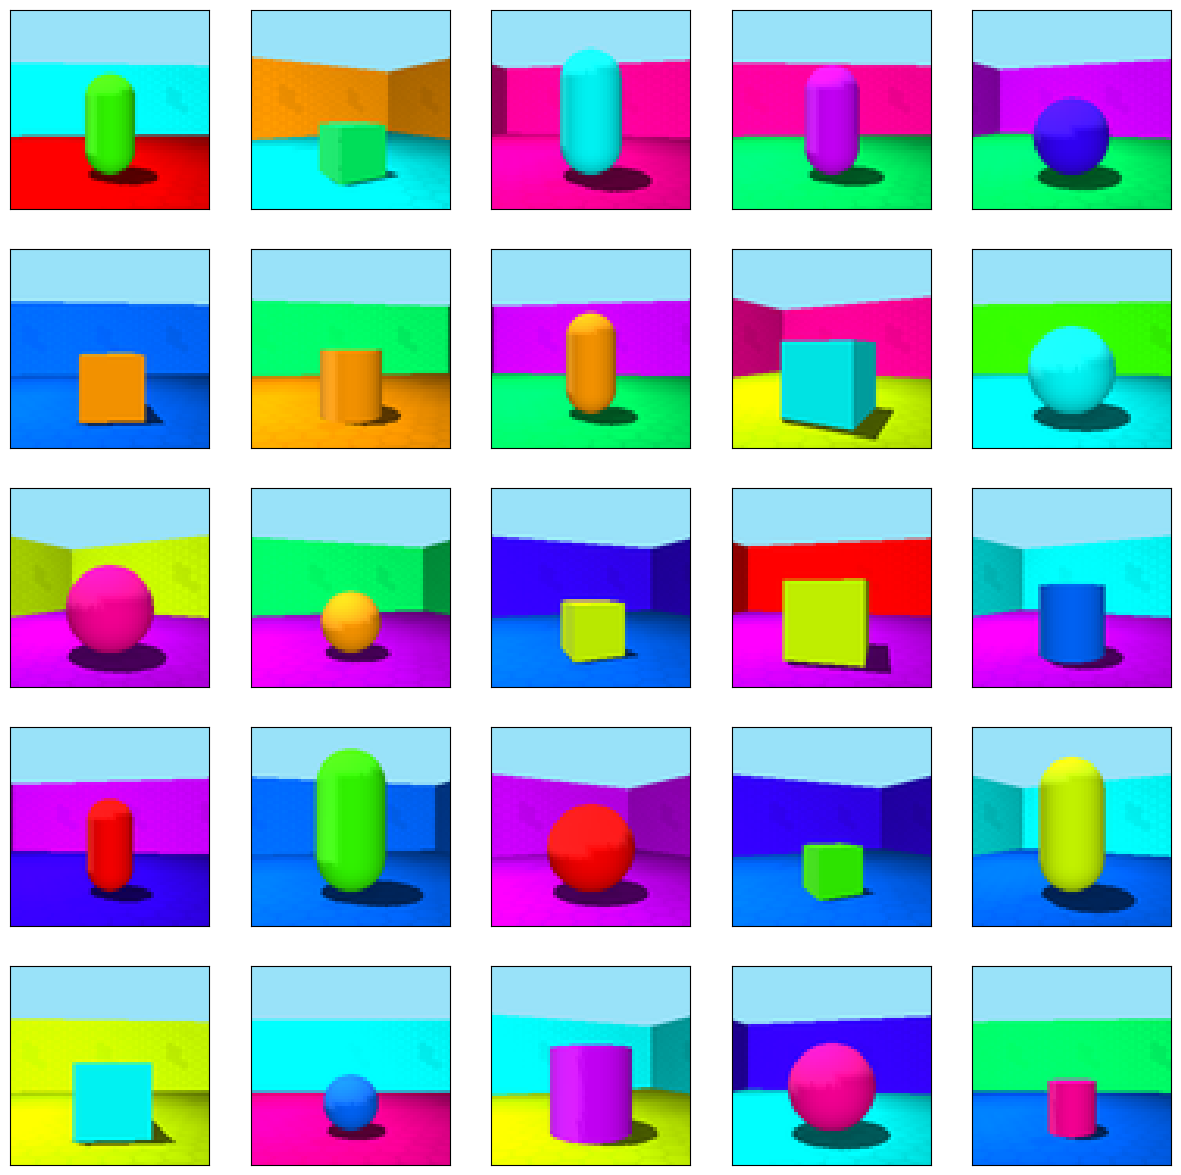

In [34]:
batch_size = 25
img_batch = sample_random_batch(batch_size)

show_images_grid(img_batch)

[11  4  7 12 13]


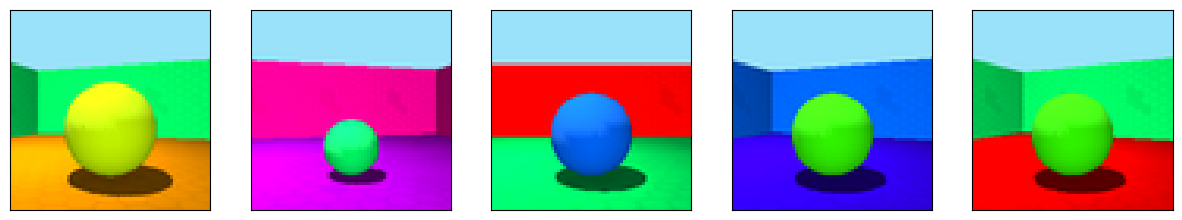

In [15]:
batch_size = 5
fixed_factor_str = 'shape' #@param ['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape', 'orientation']
fixed_factor_value = 2  # this shape corresponds to spheres
fixed_factor = _FACTORS_IN_ORDER.index(fixed_factor_str)  # floor hue
img_batch = sample_batch(batch_size, fixed_factor, fixed_factor_value)

# show_images_grid(img_batch)
show_images_row(img_batch, num_images=batch_size)


In [5]:
def sample_batch_spheres(batch_size, fixed_factor_str = 'shape', fixed_factor_value = 2, seed = 0):
  """ Samples a batch of images of spheres, with
      the other factors varying randomly.
  Args:
    batch_size: number of images to sample.
    fixed_factor: shape.
    fixed_factor_value: 2 for spheres. 
      in range(_NUM_VALUES_PER_FACTOR[_FACTORS_IN_ORDER[fixed_factor]]).

  Returns:
    X: images shape [batch_size,64*64*3]
    Y: orientation [batch_size]

  """
  np.random.seed(seed)
  fixed_factor = _FACTORS_IN_ORDER.index(fixed_factor_str)  # floor hue
  factors = np.zeros([len(_FACTORS_IN_ORDER), batch_size],
                     dtype=np.int32)
  for factor, name in enumerate(_FACTORS_IN_ORDER):
    num_choices = _NUM_VALUES_PER_FACTOR[name]
    factors[factor] = np.random.choice(num_choices, batch_size)
  factors[fixed_factor] = fixed_factor_value
  Y = factors[5]
  indices = get_index(factors)
  ims = []
  for ind in indices:
    im = images[ind]
    im = np.asarray(im)
    ims.append(im)
  ims = np.stack(ims, axis=0)
  ims = ims / 255. # normalise values to range [0,1]
  ims = ims.astype(np.float32)
  ims.reshape([batch_size, 64, 64, 3])
  X = ims.reshape([batch_size, 64*64*3])
  return X,Y

In [7]:
batch_size = 100
X, Y = sample_batch_spheres(batch_size, seed = 0)

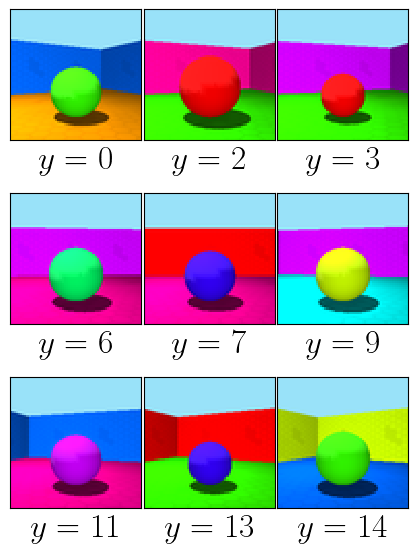

In [36]:
# sort the images by orientation Y
sorted_indices = np.argsort(Y)
X = X[sorted_indices]
Y = Y[sorted_indices]
# display the images
# reshape
X_ = X.reshape([batch_size, 64, 64, 3])
# select 5 images at 0, 5, 10, 15, 20, 25
X_ = X_[np.linspace(0, 99, 9, dtype=int)]
Y_ = Y[np.linspace(0, 99, 9, dtype=int)]
show_images_grid(X_,Y_, num_images=9)

In [41]:
Y_ 

array([ 0,  3,  7, 11, 14], dtype=int32)